In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers datasets tensorboard tqdm

In [4]:
import json, torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

DATA_PATH = Path.home() / "/content/drive/MyDrive/Colab Notebooks/mockingbird/data/tokenized_poetry_subset.json"
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

with open("/content/drive/MyDrive/Colab Notebooks/mockingbird/data/tokenized_poetry_subset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

input_ids = data["input_ids"]
attention_masks = data["attention_mask"]
print(f"Loaded {len(input_ids):,} samples.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Loaded 121,749 samples.


In [5]:
class PoetryDataset(Dataset):
    def __init__(self, input_ids, attention_masks):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
    def __len__(self):
        return len(self.input_ids)
    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_masks[idx], dtype=torch.long),
            "labels": torch.tensor(self.input_ids[idx], dtype=torch.long),
        }

dataset = PoetryDataset(input_ids, attention_masks)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [6]:
from transformers import get_scheduler
from torch.optim import AdamW
from tqdm.auto import tqdm

model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))
model.to("cuda" if torch.cuda.is_available() else "cpu")

optimizer = AdamW(model.parameters(), lr=5e-5)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

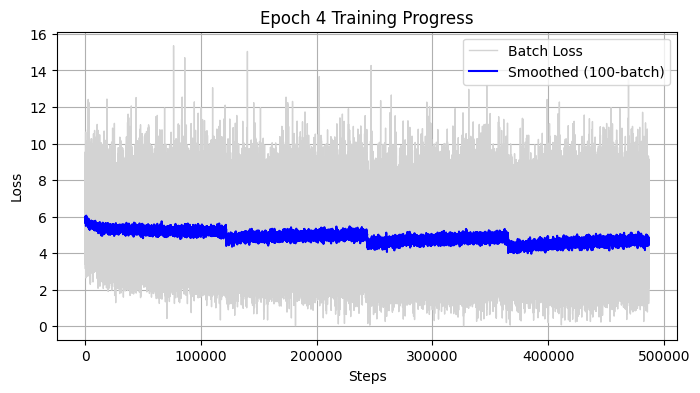

Epoch 4 average loss: 4.5525
Training complete — losses logged to TensorBoard and plotted live.


In [7]:
import torch
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.auto import tqdm
import numpy as np

writer = SummaryWriter(log_dir="./logs_iteration2")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.train()

num_epochs = 4
progress_bar = tqdm(total=len(dataloader) * num_epochs)
global_step = 0
loss_history = []

for epoch in range(num_epochs):
    total_loss = 0
    epoch_losses = []

    for batch in dataloader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        loss = outputs.loss

        # backward + update
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # bookkeeping
        total_loss += loss.item()
        epoch_losses.append(loss.item())
        writer.add_scalar("Training/Loss", loss.item(), global_step)

        # live plot
        loss_history.append(loss.item())
        if global_step % 50 == 0 and global_step > 0:
            clear_output(wait=True)
            plt.figure(figsize=(8,4))
            plt.plot(loss_history, label="Batch Loss", color="lightgray", linewidth=1)

            # only smooth if we have enough points
            if len(loss_history) >= 20:
                window = min(100, len(loss_history))
                smoothed = np.convolve(loss_history, np.ones(window)/window, mode='valid')
                plt.plot(range(window-1, len(loss_history)), smoothed, color="blue",
                        label=f"Smoothed ({window}-batch)")
            plt.xlabel("Steps")
            plt.ylabel("Loss")
            plt.title(f"Epoch {epoch+1} Training Progress")
            plt.legend()
            plt.grid(True)
            plt.show()

        progress_bar.update(1)
        global_step += 1

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")
    writer.add_scalar("Training/Epoch_Avg_Loss", avg_loss, epoch+1)

writer.close()
torch.save(model.state_dict(), f"mockingbird_baseline_epoch{num_epochs}.pt")
print("Training complete — losses logged to TensorBoard and plotted live.")

In [8]:
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/mockingbird/data"
MODEL_DIR = "/content/drive/MyDrive/"
model.save_pretrained(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)

('/content/drive/MyDrive/tokenizer_config.json',
 '/content/drive/MyDrive/special_tokens_map.json',
 '/content/drive/MyDrive/vocab.json',
 '/content/drive/MyDrive/merges.txt',
 '/content/drive/MyDrive/added_tokens.json',
 '/content/drive/MyDrive/tokenizer.json')

In [3]:
!mkdir -p "/content/drive/MyDrive/mockingbird_model"

In [4]:
!mv /content/drive/MyDrive/config.json \
     /content/drive/MyDrive/generation_config.json \
     /content/drive/MyDrive/model.safetensors \
     /content/drive/MyDrive/tokenizer* \
     /content/drive/MyDrive/vocab.json \
     /content/drive/MyDrive/merges.txt \
     /content/drive/MyDrive/special_tokens_map.json \
     "/content/drive/MyDrive/mockingbird_model/"

In [7]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
MODEL_DIR = "/content/drive/MyDrive/mockingbird_model"
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_DIR)
model = GPT2LMHeadModel.from_pretrained(MODEL_DIR)

In [8]:
model.eval()
prompt = "Sing softly of the moonlight"
inputs = tokenizer(prompt, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_length=40, num_return_sequences=3, temperature=0.9, do_sample=True, top_k=50, top_p=0.95)
for i, o in enumerate(outputs):
    print(f"\nSample {i+1}:\n", tokenizer.decode(o, skip_special_tokens=True))

NameError: name 'device' is not defined

In [ ]:
!tensorboard --logdir ./logs_iteration2/ --port 6006

/usr/local/lib/python3.12/dist-packages/tensorboard/_vendor/bleach/sanitizer.py:292: SyntaxWarning: invalid escape sequence '\s'
  "[`\000-\040\177-\240\s]+",
/usr/local/lib/python3.12/dist-packages/tensorboard/_vendor/bleach/sanitizer.py:339: SyntaxWarning: invalid escape sequence '\s'
  style = re.compile('url\s*\(\s*[^\s)]+?\s*\)\s*').sub(' ', style)
/usr/local/lib/python3.12/dist-packages/tensorboard/_vendor/bleach/sanitizer.py:354: SyntaxWarning: invalid escape sequence '\s'
  if not re.match("^\s*([-\w]+\s*:[^:;]*(;\s*|$))*$", style):
/usr/local/lib/python3.12/dist-packages/tensorboard/_vendor/bleach/sanitizer.py:358: SyntaxWarning: invalid escape sequence '\w'
  for prop, value in re.findall('([-\w]+)\s*:\s*([^:;]*)', style):
2025-11-01 22:39:39.594017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762036779.621032   58954 cuda_dnn.

In [9]:
import json, torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from math import exp

In [11]:
# Load fine-tuned model and tokenizer
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
MODEL_DIR = "/content/drive/MyDrive/mockingbird_model"
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_DIR)
model = GPT2LMHeadModel.from_pretrained(MODEL_DIR)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [13]:
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
prompt = "Sing softly of the moonlight"
inputs = tokenizer(prompt, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_length=40, num_return_sequences=3, temperature=0.9, do_sample=True, top_k=50, top_p=0.95)
for i, o in enumerate(outputs):
    print(f"\nSample {i+1}:\n", tokenizer.decode(o, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Sample 1:
 Sing softly of the moonlight and you; dear dear eyes, dear eyes, and hear, and think, I, O dear. You, and I, I, they, and hear. dance

Sample 2:
 Sing softly of the moonlight and of sun, sleep, and sleep. I, all in fear, and sleep. But one. I know. I go, alone. I, not. But

Sample 3:
 Sing softly of the moonlight, you are fair, I say, my love. I lie; and go; I know, nor;--I know. O?--I--I am alone


Model and tokenizer loaded.


  0%|          | 0/200 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


  0%|          | 0/200 [00:00<?, ?it/s]


Train Loss: 3.920, Perplexity: 50.42
Val   Loss: 3.822, Perplexity: 45.71


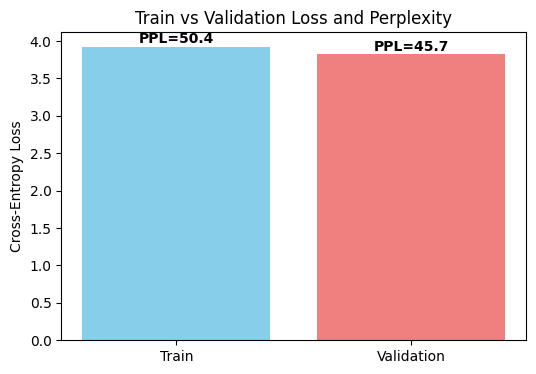

In [14]:
import json, torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from math import exp
from torch.nn.utils.rnn import pad_sequence

device = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_DIR = "/content/drive/MyDrive/mockingbird_model"
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/mockingbird/data/tokenized_poetry_subset.json"

tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_DIR)
model = GPT2LMHeadModel.from_pretrained(MODEL_DIR).to(device)
model.eval()

print("Model and tokenizer loaded.")

with open(DATA_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

input_ids = data["input_ids"]
attention_masks = data["attention_mask"]

class PoetryDataset(Dataset):
    def __init__(self, input_ids, attention_masks):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
    def __len__(self): return len(self.input_ids)
    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_masks[idx], dtype=torch.long),
            "labels": torch.tensor(self.input_ids[idx], dtype=torch.long),
        }

full_dataset = PoetryDataset(input_ids, attention_masks)
train_size = int(0.9 * len(full_dataset))
val_size   = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

def collate_batch(batch):
    # each element is a dict with input_ids, attention_mask, labels
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    # pad to max length in this batch
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)  # -100 tells loss to ignore padding

    return {
        "input_ids": input_ids,
        "attention_mask": attention_masks,
        "labels": labels
    }

def evaluate_perplexity(model, dataset, max_batches=200):
    loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_batch)
    total_loss, steps = 0, 0
    with torch.no_grad():
        for batch in tqdm(loader, total=min(len(loader), max_batches)):
            if steps >= max_batches:
                break
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)
            total_loss += outputs.loss.item()
            steps += 1
    avg_loss = total_loss / steps
    ppl = exp(avg_loss)
    return avg_loss, ppl

train_loss, train_ppl = evaluate_perplexity(model, train_dataset)
val_loss, val_ppl     = evaluate_perplexity(model, val_dataset)

print(f"\nTrain Loss: {train_loss:.3f}, Perplexity: {train_ppl:.2f}")
print(f"Val   Loss: {val_loss:.3f}, Perplexity: {val_ppl:.2f}")

labels = ['Train', 'Validation']
losses = [train_loss, val_loss]
ppl_values = [train_ppl, val_ppl]

fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(labels, losses, color=['skyblue','lightcoral'])
ax.set_ylabel('Cross-Entropy Loss')
ax.set_title('Train vs Validation Loss and Perplexity')

for i, v in enumerate(ppl_values):
    ax.text(i, losses[i]+0.05, f"PPL={v:.1f}", ha='center', fontweight='bold')

plt.show()

In [15]:
# -------------------------------------------------------------
# 0. Setup
# -------------------------------------------------------------
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------------------------------------
# 1. Load original pretrained GPT-2
# -------------------------------------------------------------
tokenizer_orig = GPT2TokenizerFast.from_pretrained("gpt2")
model_orig = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model_orig.eval()

# -------------------------------------------------------------
# 2. Load your fine-tuned GPT-2
# -------------------------------------------------------------
FINE_TUNED_DIR = "/content/drive/MyDrive/mockingbird_model"   # path where you saved the model
tokenizer_ft = GPT2TokenizerFast.from_pretrained(FINE_TUNED_DIR)
model_ft = GPT2LMHeadModel.from_pretrained(FINE_TUNED_DIR).to(device)
model_ft.eval()

# -------------------------------------------------------------
# 3. Define sample prompts
# -------------------------------------------------------------
prompts = [
    "Sing softly of the moonlight",
    "Whisper to the stars above",
    "Dance under the silver rain",
    "Love is but a fleeting dream",
    "In the garden of midnight roses"
]

# generation parameters
gen_kwargs = {
    "max_length": 40,
    "temperature": 0.9,
    "top_p": 0.95,
    "do_sample": True,
    "repetition_penalty": 1.1,
}

# -------------------------------------------------------------
# 4. Generate and compare
# -------------------------------------------------------------
def generate_text(model, tokenizer, prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, **gen_kwargs)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

comparisons = []

for prompt in tqdm(prompts):
    out_orig = generate_text(model_orig, tokenizer_orig, prompt)
    out_ft   = generate_text(model_ft, tokenizer_ft, prompt)
    comparisons.append((prompt, out_orig, out_ft))

# -------------------------------------------------------------
# 5. Display side-by-side comparison
# -------------------------------------------------------------
import pandas as pd
df = pd.DataFrame(comparisons, columns=["Prompt", "Original GPT-2", "Fine-tuned GPT-2"])
pd.set_option("max_colwidth", None)
df


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


,Prompt,Original GPT-2,Fine-tuned GPT-2
0,Sing softly of the moonlight,"Sing softly of the moonlight, ""You say I'm not one to lose you?""\n\n""No. It's true,"" He smiled; it was a very pleasant and flattering look at him","Sing softly of the moonlight, do you hear? O dear Love, O Love; die; O Love! hate! no love.'. He said. -- he, dead. then! he"
1,Whisper to the stars above,"Whisper to the stars above your head.\nI've always believed that when it comes to movies, there is just too much of a certain amount of magic and imagination in them… You don","Whisper to the stars above it. All the sky, above, below! above! below?--the air? To-day--well--hite?-day--thine!"
2,Dance under the silver rain,"Dance under the silver rain. The sky was clear as night, and no one heard from him until after he had gone down to see if they would stay awake—except perhaps his father who remained","Dance under the silver rain, and hear the cheer; and then--he tears. -- 'tis hot! hot! red! hot! red! red!'--and cold! white! hot"
3,Love is but a fleeting dream,Love is but a fleeting dream.,"Love is but a fleeting dream, and I hear the voice. I know, dear; and then! we cry. then, there. I say no! I go, it's gone. I"
4,In the garden of midnight roses,"In the garden of midnight roses, I know that my son loves me. And he tells me all about it and how to be a good husband—and with great pleasure she teaches him very well;","In the garden of midnight roses, I had found him dead, who stood; then--he--I saw him, a-nay. now--I. `I: 'tis a boy"


In [16]:
import json

output_json = []
for prompt, out_orig, out_ft in comparisons:
    output_json.append({
        "prompt": prompt,
        "original_gpt2_output": out_orig,
        "fine_tuned_gpt2_output": out_ft
    })

SAVE_PATH = "/content/drive/MyDrive/gpt2_vs_finetuned_results.json"
with open(SAVE_PATH, "w", encoding="utf-8") as f:
    json.dump(output_json, f, indent=2, ensure_ascii=False)

print(f"✅ Saved comparison results to {SAVE_PATH}")

✅ Saved comparison results to /content/drive/MyDrive/gpt2_vs_finetuned_results.json
